<img style="float: left;" src="earth-lab-logo-rgb.png" width="150" height="150" />

# Earth Analytics Education - EA  Python Course Spring 2021

## Important  - Assignment Guidelines

1. Before you submit your assignment to GitHub, make sure to run the entire notebook with a fresh kernel. To do this first, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart & Run All)
2. Always replace the `raise NotImplementedError()` code with your code that addresses the activity challenge. If you don't replace that code, your notebook will not run.

```
# YOUR CODE HERE
raise NotImplementedError()
```

3. Any open ended questions will have a "YOUR ANSWER HERE" within a markdown cell. Replace that text with your answer also formatted using Markdown.
4. **DO NOT RENAME THIS NOTEBOOK File!** If the file name changes, the autograder will not grade your assignment properly.
6. When you create a figure, comment out `plt.show()` to ensure the autograder can grade your plots. For figure cells, DO NOT DELETE the code that says `DO NOT REMOVE LINE BELOW`.

```
### DO NOT REMOVE LINE BELOW ###
student_plot1_ax = nb.convert_axes(plt)
```

* Only include the package imports, code, and outputs that are required to run your homework assignment.
* Be sure that your code can be run on any operating system. This means that:
   1. the data should be downloaded in the notebook to ensure it's reproducible
   2. all paths should be created dynamically using the `os.path.join`

## Follow to PEP 8 Syntax Guidelines & Documentation

* Run the `autopep8` tool on all cells prior to submitting (HINT: hit shift + the tool to run it on all cells at once!
* Use clear and expressive names for variables. 
* Organize your code to support readability.
* Check for code line length
* Use comments and white space sparingly where it is needed
* Make sure all python imports are at the top of your notebook and follow PEP 8 order conventions
* Spell check your Notebook before submitting it.

For all of the plots below, be sure to do the following:

* Make sure each plot has a clear TITLE and, where appropriate, label the x and y axes. Be sure to include UNITS in your labels.


### Add Your Name Below 
Leah Manak


<img style="float: left;" src="colored-bar.png"/>

---

# Week 04 and 05 Homework - Automate NDVI Workflow

For this assignment, you will write code to generate a plot of the mean normalized difference vegetation index (NDVI) for two different sites in the United States across one year of data:

* San Joaquin Experimental Range (SJER) in Southern California, United States
* Harvard Forest (HARV) in the Northeastern United States

The data that you will use for this week is available from **earthpy** using the following download: 

`et.data.get_data('ndvi-automation')`

## Assignment Goals

Your goal in this assignment is to create the most efficient and concise workflow that you can that allows for:

1. The code to scale if you added new sites or more time periods to the analysis.
2. Someone else to understand your workflow.
3. The LEAST and most efficient (i.e. runs fast, minimize repetition) amount of code that completes the task.

### HINTS

* Remove values outside of the landsat valid range of values as specified in the metadata, as needed.
* Keep any output files SEPARATE FROM input files. Outputs should be created in an outputs directory that is created in the code (if needed) and/or tested for.
* Use the functions that we demonstrated during class to make your workflow more efficient.
* BONUS - if you  chose - you can export your data as a csv file. You will get bonus points for doing this.


## Assignment Requirements

Your submission to the GitHub repository should include:
* This Jupyter Notebook file (.ipynb) with:
    * The code to create a plot of mean NDVI across a year for  2 NEON Field Sites:
        * NDVI on the x axis and formatted dates on the y for both NEON sites on one figure/axis object
    * The **data should be cleaned to remove the influence of clouds**. See the [earthdatascience website for an example of what your plot might look like with and without removal of clouds](https://www.earthdatascience.org/courses/earth-analytics-python/create-efficient-data-workflows/).
* BONUS: Create one output `.csv` file that has 3 columns - NDVI, Date and Site Name - with values for SJER and HARV.

Your notebook should:
* Have *at least* 2 well documented and well named functions with docstrings.
* Include a Markdown cell at the top of the notebook that outlines the overall workflow using pseudocode (i.e. plain language, not code)
* Include additional Markdown cells throughout the notebook to describe: 
    * the data that you used - and where it is from
    * how data are being processing
    * how the code is optimized to run fast and be more concise

# Replace this cell with your pseudocode  for this workflow

If you happen to be a diagram person a diagram is ok too



# Pseudocode for assignment workflow

- Import libraries that will be used in this notebook
- Make sure unused libraries are not in the list
- Get the home directory using "et.data.get_data('ndvi-automation')"
- Create data paths to our data from 'ndvi-automation' downloaded from earthpy
- Create cloud mask and get cloud pixel values from earthpy
- Create two functions: 
    1. extract the sitename and datetime from pathnames
    2. open, crop, and identify ranges of a landsat band
- Clip extent of bands to match study sites boundaries
- Clip extent of qa layers to match study sites boundaries
- Calculate NDVI 
- Add a cloud mask to the NDVI values
- Calculate Mean NDVI, get site names and the dates, and create a list of lists
- Make a pandas dataframe including the site names, mean NDVIs, and dates 
- Make sure the dataframe index is in datetime and that the date column is the index
- Make sure the NA data is not included
- Plot the data with date on the x-axis and mean NDVI values on the y axis
- Download the data to a CSV file

In [1]:
# Autograding imports - do not modify this cell
import matplotcheck.autograde as ag
import matplotcheck.notebook as nb
import matplotcheck.timeseries as ts
from datetime import datetime

In [2]:
# Import needed packages in PEP 8 order
# and no unused imports listed (10 points total)
import os
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
import earthpy as et
import earthpy.mask as em
from datetime import datetime
import numpy as np
from matplotlib.dates import DateFormatter

# Download the data
et.data.get_data('ndvi-automation')

# Create a path to the directory
directory_path = os.path.join(et.io.HOME,
                              "earth-analytics",
                              "data")

# Set working directory
os.chdir(directory_path)

In [3]:
# DO NOT MODIFY THIS CELL
# Tests that the working directory is set to earth-analytics/data

path = os.path.normpath(os.getcwd())
student_wd_parts = path.split(os.sep)

if student_wd_parts[-2:] == ['earth-analytics', 'data']:
    print("\u2705 Great - it looks like your working directory is set correctly to ~/earth-analytics/data")
else:
    print("\u274C Oops, the autograder will not run unless your working directory is set to earth-analytics/data")

✅ Great - it looks like your working directory is set correctly to ~/earth-analytics/data


# Figure 1: Plot 1 - Mean NDVI For Each Site Across the Year (50 points)

Create a plot of the mean normalized difference vegetation index (NDVI) for the two different sites in the United States across the year: 

* NDVI on the x axis and formatted dates on the y for both NEON sites on one figure/axis object.
* Each site should be identified with a different color in the plot and legend.
* The final plot **data should be cleaned to remove the influence of clouds**.
* Be sure to include appropriate title and axes labels.

Add additional cells as needed for processing data (e.g. defining functions, etc), but be sure to:
* follow the instructions in the code cells that have been provided to ensure that you are able to use the sanity check tests that are provided. 
* include only the plot code in the cell identified for the final plot code below

## Task 1: 

In the cell below, create a single dataframe containing MEAN NDVI, the site name, 
and the date of the data for the HARV site 
scene `HARV/landsat-crop/LC080130302017031701T1-SC20181023151837`.  The column names for the  final
DataFrame should be`mean_ndvi`, and `site`, and the data should be **indexed on the date**. 

Use the functions that we reviewed in class (or create your own versions of them) to implement your code

### In the Cell below Place  All Functions Needed to Run this Notebook (20 points)

In [4]:
### DO NOT REMOVE THIS LINE OR EDIT / MOVE THIS CELL ###
start_time = datetime.now()

In [5]:
# In this cell place all of the functions needed to run your notebook
# You will be graded here on function application, docstrings, efficiency so ensure
# All functions are placed here!

# A function to extract the datetime and sitename from the directory paths
def extract_date_sitename(directory_path,
                          sitename_location,
                          datetime_location):
    """Extract datetime and sitename from directory path names.

    Parameters
    -----------
    directory_path : string
        A path to the directory name
    sitename_location : index list
        Index of sitename location in directory path name
    datetime_location : index list
        Index of datetime location in directory path name

    Returns
    -----------
    list : list of the datetime location and sitename information
    """
    # Create an empty list to append both sitename and date information
    sitename_date = []

    # Assign datetime location to an object and specify datetime format
    date_location = directory_path[datetime_location[0]: datetime_location[1]]
    format = "%Y%m%d"

    # Create a date varaiable using new object and the datetime format
    date = datetime.strptime(date_location, format)

    # Create a location variable called "site"
    site = directory_path[sitename_location[0]: sitename_location[1]]

    # Append site and date variables to list
    sitename_date.append(site)
    sitename_date.append(date)
    
    # Return the populated sitename_date list
    return sitename_date

# A function to open clean landsat bands
def open_clean_bands(band_path,
                     crop_extent,
                     valid_range=None):
    """Open, crop, and identify the range of the bands.

    Parameters
    -----------
    band_path : string
        A path to the array that we will open
    valid_range : tuple (optional)
        A tuple of min and max range of values for the data. Default = None

    Returns
    -----------
    arr : xarray DataArray
        An xarray DataArray with values that should be masked
        set to 1 for True (Boolean)
    """
    # tests to ensure the arrays are clipped to the same .shape
    band = rxr.open_rasterio(
        band_path, masked=True).rio.clip(
        crop_extent.geometry,from_disk=True).squeeze()

    # This last step is only for a valid tuple
    if valid_range:
        mask = ((band < valid_range[0]) | (band > valid_range[1]))
        band = band.where(~xr.where(mask, True, False))

    return band

In [6]:
# Create dataframe of mean NDVI in this cell using the functions created above

# Create path to the two sites "SJER" and "HARV"
site_paths = glob(os.path.join("ndvi-automation",
                               "sites",
                               "*"))
site_paths

# Create cloud mask and get the cloud pixel values from earthpy
high_cloud_confidence = (
    em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"])
cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

all_masked_values = cloud_shadow + cloud + high_cloud_confidence
harv_path = glob(os.path.join("ndvi-automation", "sites", "HARV"))

# Open and clean all HARV: first create empty HARV list
harv_info = []

# Create a for loop for the HARV path
for path in harv_path:
    # Establish the scene directory path 
    scene_path = glob(os.path.join(path, "landsat-crop",
                      "LC080130302017031701T1-SC20181023151837"))
    # Set the path to the cropped shapefile and open as the HARV boundary
    bound = os.path.join(path, "vector", "HARV-crop.shp")
    harv_boundary = gpd.read_file(bound)

    # Create a nested for loop associated with each .tif file (band 4-5)
    for tifs in scene_path:
        # Get site and date info from the scene directory path
        site_info = extract_date_sitename(tifs, [22, 26], [50, 58])
        # Order the bands 4-5 with glob
        harv_bands = sorted(glob(os.path.join(tifs, "*band[4-5]*")))
        # Set the path to the qa layer in the scene directory and open it
        qa_layer_path = os.path.join(tifs,
                                     "LC08_L1TP_013030_20170317_20170328_01_T1_pixel_qa.tif")
        qa_layer = rxr.open_rasterio(qa_layer_path, masked=True)
        # Crop the qa layer using the harv_boundary 
        cropped_qa = qa_layer.rio.clip(harv_boundary.geometry).squeeze()

        # New empty list for bands without cloud interference
        tif_bands = []
        # Create an additional loop for the bands in harv
        for a_band in harv_bands:
            # Clean the band using the open_clean_bands function
            clean_band = open_clean_bands(
                a_band, harv_boundary, valid_range=(0, 10000))
            # Apply the cloud mask to the clean band
            band_cloud_mask = clean_band.where(
                ~qa_layer.isin(all_masked_values))
            # Add clean bands to empty for calculating the mean NDVI
            tif_bands.append(band_cloud_mask)

        # Calculate mean NDVI using tif_bands list
        mean_ndvi = np.nanmean(
            (tif_bands[1]-tif_bands[0]) / (tif_bands[1]+tif_bands[0]))
        # Append the mean NDVI to the site_info list
        site_info.append(mean_ndvi)
        # Append site_info list to the initial list prior to the for loop
        #called "harv_info"
        harv_info.append(site_info)

# Create a pandas dataframe with the harv_info list
harv_df = pd.DataFrame(harv_info, columns=[
                            "site", "date", "mean_ndvi"])

# Set index from the date
harv_final = harv_df.set_index("date")

# Call dataframe
harv_final


,site,mean_ndvi
date,,
2017-03-17,HARV,0.281132


In [7]:
# This cell  is testing your data output above

student_ndvi_ts_single_site = _

single_scene_points = 0

# Ensure the data is stored in a dataframe.
if isinstance(student_ndvi_ts_single_site, pd.DataFrame):
    print('\u2705 Your data is stored in a DataFrame!')
    single_scene_points += 1
else:
    print('\u274C It appears your data is not stored in a DataFrame. ',
          'To see what type of object your data is stored in, check its type with type(object)')

# Ensure that the date column is the index
if isinstance(student_ndvi_ts_single_site.index, pd.core.indexes.datetimes.DatetimeIndex):
    print('\u2705 You have the index set to the date column!')
    single_scene_points += 2
else:
    print('\u274C You do not have the index set to the date column.')

# Ensure that the date column is datetime
if isinstance(student_ndvi_ts_single_site.index[0], pd._libs.tslibs.timestamps.Timestamp):
    print('\u2705 The data in your date column is datetime!')
    single_scene_points += 2
else:
    print('\u274C The data in your date column is not datetime.')

# Ensure the site name is correct
if student_ndvi_ts_single_site.site.values[0] == 'HARV':
    print('\u2705 You have the correct site name!')
    single_scene_points += 5
else:
    print('\u274C You do not have the correct site name.')

if np.allclose(0.281131628228094, student_ndvi_ts_single_site.mean_ndvi.values[0]):
    print('\u2705 You have the correct mean NDVI value!')
    single_scene_points += 5
else:
    print('\u274C You do not have the correct mean ndvi value.')

print("\n \u27A1 You received {} out of 15 points for creating a dataframe.".format(
    single_scene_points))
single_scene_points

✅ Your data is stored in a DataFrame!
✅ You have the index set to the date column!
✅ The data in your date column is datetime!
✅ You have the correct site name!
✅ You have the correct mean NDVI value!

 ➡ You received 15 out of 15 points for creating a dataframe.


15

## Task 2:

In the cell below, process all of the landsat scenes. Create a DataFrame that contains the following 
information for each scene


|   | index  | site  | mean_ndvi  | 
|---|---|---|---|
| Date  |   |   |   |
|  2017-01-07  | 0  | SJER  | .4  |  

Be sure to call your dataframe at the end of the cell to ensure autograding works.
HINT: FOR THIS STEP, leave any rows containing missing values (`NAN`).

In [8]:
# Create dataframe of NDVI including the cleaning data to deal with clouds

# YOUR CODE HERE
# Create an empty list with site, date, and mean ndvi information
location_info = []

# make a for loop for the location paths
for site in site_paths:
    # Get list of the location path with glob
    locations = glob(os.path.join(site, "landsat-crop", "*"))
    # grab the shapefiles from the locations and make the index 0
    bounds = glob(os.path.join(site, "vector", "*-crop.shp"))[0]
    # Open the shapefiles
    opened_bound = gpd.read_file(bounds)

    # Create a nested for loop for all locations
    for all_locations in locations:
        # Extract date and site info using "extract_date_sitename" function
        site_info = extract_date_sitename(all_locations, [22, 26], [50, 58])
        # Create sorted list of bands 5 & 5 in each location using glob
        scene_bands = sorted(glob(os.path.join(all_locations, "*band[4-5]*")))
        # Extract qa pixel layers using glob and pulling out index 0. 
        qa_layer_paths = glob(os.path.join(all_locations, "*pixel_qa*"))[0]
        # Open the qa layer
        opened_layer = rxr.open_rasterio(qa_layer_paths, masked=True)
        # Crop the qa layer using the 'opened_layer' shapefile
        cropped_layer = opened_layer.rio.clip(opened_bound.geometry).squeeze()

        # Create an empty list for cleaned bands 4 and 5 
        site_bands = []

        # Create a for loop to clean bands 4&5
        for band in scene_bands:
            # Clean the bands using 'open_clean_bands' function
            clean_band = open_clean_bands(
                band, opened_bound, valid_range=(0, 10000))
            # Apply cloud mask 
            cloud_free_band = clean_band.where(
                ~cropped_layer.isin(all_masked_values))
            # Append list with the cloud free bands
            site_bands.append(cloud_free_band)

        # Calculate mean NDVI
        mean_ndvi = np.nanmean(
            (site_bands[1]-site_bands[0]) / (site_bands[1]+site_bands[0]))
        # Append the mean NDVI to the empty site_info list
        site_info.append(mean_ndvi)
        # Append this list of lists the empty location_info list
        location_info.append(site_info)

# Create a pandas dataframe
location_info_df = pd.DataFrame(location_info, columns=[
                            "site", "date", "mean_ndvi"])

# Set index on date
indexed_location_df = location_info_df.set_index("date")

final_NDVI_df = indexed_location_df.sort_values(by="date")

# Call dataframe
final_NDVI_df

/var/folders/vm/pq3w52910cd2h9mmkrzvgqxc0000gn/T/ipykernel_5180/3608888154.py:44: RuntimeWarning: Mean of empty slice
  mean_ndvi = np.nanmean(
/var/folders/vm/pq3w52910cd2h9mmkrzvgqxc0000gn/T/ipykernel_5180/3608888154.py:44: RuntimeWarning: Mean of empty slice
  mean_ndvi = np.nanmean(
/var/folders/vm/pq3w52910cd2h9mmkrzvgqxc0000gn/T/ipykernel_5180/3608888154.py:44: RuntimeWarning: Mean of empty slice
  mean_ndvi = np.nanmean(
/var/folders/vm/pq3w52910cd2h9mmkrzvgqxc0000gn/T/ipykernel_5180/3608888154.py:44: RuntimeWarning: Mean of empty slice
  mean_ndvi = np.nanmean(
/var/folders/vm/pq3w52910cd2h9mmkrzvgqxc0000gn/T/ipykernel_5180/3608888154.py:44: RuntimeWarning: Mean of empty slice
  mean_ndvi = np.nanmean(
/var/folders/vm/pq3w52910cd2h9mmkrzvgqxc0000gn/T/ipykernel_5180/3608888154.py:44: RuntimeWarning: Mean of empty slice
  mean_ndvi = np.nanmean(
/var/folders/vm/pq3w52910cd2h9mmkrzvgqxc0000gn/T/ipykernel_5180/3608888154.py:44: RuntimeWarning: Mean of empty slice
  mean_ndvi = np.n

,site,mean_ndvi
date,,
2017-01-07,SJER,NaN
2017-01-12,HARV,NaN
2017-01-23,SJER,NaN
2017-01-28,HARV,NaN
2017-02-08,SJER,NaN
2017-02-13,HARV,NaN
2017-02-24,SJER,0.665524
2017-03-01,HARV,NaN
2017-03-12,SJER,0.664109


In [9]:
# Last sanity check before creating your plot (10 points)

# Ensure that you call your dataframe at the bottom of the cell above
# and that it has columns called: mean_ndvi and site

# Ensure the data is stored in a dataframe.
student_ndvi_df = _

df_points = 0

if isinstance(student_ndvi_df, pd.DataFrame):
    print('\u2705 Your data is stored in a DataFrame!')
    df_points +=2
else:
    print('\u274C It appears your data is not stored in a DataFrame. ',
          'To see what type of object your data is stored in, check its type with type(object)')

# Check that dataframe contains the appropriate number of NAN values
if student_ndvi_df.mean_ndvi.isna().sum() == 15:
    print('\u2705 Correct number of masked data values!')
    df_points +=2
else:
    print('\u274C The amount of null data in your dataframe is incorrect.')


# Ensure that the date column is the index
if isinstance(student_ndvi_df.index, pd.core.indexes.datetimes.DatetimeIndex):
    print('\u2705 You have the index set to the date column!')
    df_points +=3
else:
    print('\u274C You do not have the index set to the date column.')

# Ensure that the date column is datetime
if isinstance(student_ndvi_df.index[0], pd._libs.tslibs.timestamps.Timestamp):
    print('\u2705 The data in your date column is datetime!')
    df_points +=3
else:
    print('\u274C The data in your date column is not datetime.')

# Output for timer, # DO NOT MODIFY
end_time = datetime.now()
total_time = end_time - start_time
print(
    "Your total run time for processing the data was {0}.".format(total_time))

print("\n \u27A1 You received {} out of 10 points for creating a dataframe.".format(
    df_points))

df_points

✅ Your data is stored in a DataFrame!
✅ Correct number of masked data values!
✅ You have the index set to the date column!
✅ The data in your date column is datetime!
Your total run time for processing the data was 0:00:08.659740.

 ➡ You received 10 out of 10 points for creating a dataframe.


10

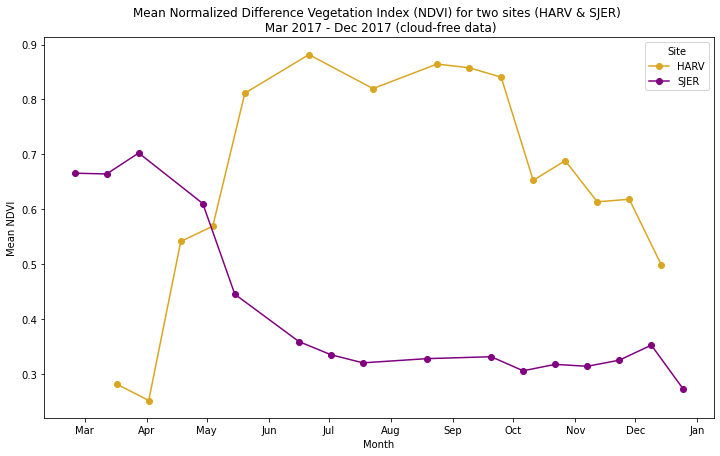

In [10]:
# Add only the plot code to this cell

# This is the final figure of mean NDVI
# for both sites across the year
# with data cleaned to deal with clouds

fig, ax = plt.subplots(figsize = (12, 7))


for site, df in final_NDVI_df.dropna().groupby("site"):
    if site in ["HARV"]:
        site_name = 'HARV'
        color = 'goldenrod'
    else:
        site_name = 'SJER'
        color = 'purple'

    ax.plot(df.index, df.mean_ndvi, label = site_name, marker = 'o',
            color = color)
    
ax.set(title = "Mean Normalized Difference Vegetation Index (NDVI)\
 for two sites (HARV & SJER) \n Mar 2017 - Dec 2017 (cloud-free data)", 
       xlabel = "Month", ylabel = "Mean NDVI")

ax.xaxis.set_major_formatter(DateFormatter("%b"))
    
ax.legend(title = "Site")


### DO NOT REMOVE LINES BELOW ###
final_masked_solution = nb.convert_axes(plt, which_axes="current")

In [11]:
# Ignore this cell for the autograding tests


In [12]:
# Ignore this cell for the autograding tests


# Question 1 (10 points)

Imagine that you are planning NEON’s upcoming flight season to capture remote sensing data in these locations and want to ensure that you fly the area when the vegetation is the most green.

When would you recommend the flights take place for each site? 

Answer the question in 2-3 sentences in the Markdown cell below.

Based on the plot, I would recommend the flights to take place in different times for the different locations. I would say April for the SJER site, and July for the HARV site.

# Question 2 (10 points)

How could you modify your workflow to look at vegetation changes over time in each site? 

Answer the question in 2-3 sentences in the Markdown cell below.

Instead of comparing the two sites, I would create a separate plot for each site. Each location plot would have a line for each year as a separate color, showing how the vegetation might change each month over a span of a certain amount of years. 

# Do not edit this cell! (10 points)

The notebook includes:
* additional Markdown cells throughout the notebook to describe: 
    * the data that you used - and where it is from
    * how data are being processing
    * how the code is optimized to run fast and be more concise

# Do not edit this cell! (20 points)

The notebook will also be checked for overall clean code requirements as specified at the **top** of this notebook. Some of these requirements include (review the top cells for more specifics): 

* Notebook begins at cell [1] and runs on any machine in its entirety.
* PEP 8 format is applied throughout (including lengths of comment and code lines).
* No additional code or imports in the notebook that is not needed for the workflow.
* Notebook is fully reproducible. This means:
   * reproducible paths using the os module.
   * data downloaded using code in the notebook.
   * all imports at top of notebook.

## BONUS - Export a  .CSV File to Share (10 points possible)

This is optional - if you export a **.csv** file with the columns specified above: Site, Date and NDVI Value you can get an additional 10 points.

* FULL CREDIT: File exists in csv format and contains the columns specified.
We will check your github repo for this file!


In [13]:
# CSV needs to have no nan values... drop them with .dropna()
final_NDVI_df_csv = final_NDVI_df.dropna()

# Export pandas dataframe to csv file
final_NDVI_df_csv.to_csv(os.path.join(
    directory_path,
    "ndvi-automation",
    "outputs", 
    "ndvi_df.csv"))

# Export to personal
final_NDVI_df_csv.to_csv(os.path.join(et.io.HOME,
                                      "earth-analytics",
                                      "earth-analytics-python-env",
                                      "ea-2022-04-ndvi-automation-LManak",
                                      "ndvi_df.csv"))